## Import & Basic Settings

In [1]:
import pandas as pd
import os
from tqdm import tqdm
from dotenv import load_dotenv

from konlpy.tag import Okt
import numpy as np
from sklearn.preprocessing import normalize

from langchain_openai.embeddings import OpenAIEmbeddings
from sklearn.metrics.pairwise import cosine_similarity

from typing_extensions import TypedDict
from typing import Annotated
from langchain_core.messages import (
    HumanMessage,
    SystemMessage
)
from langchain_openai import ChatOpenAI
from pydantic import BaseModel
from langgraph.graph import StateGraph, START, END

from keybert import KeyBERT
from transformers import BertModel

from difflib import SequenceMatcher

/opt/anaconda3/envs/company_breif_pjt/lib/python3.10/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(
/opt/anaconda3/envs/company_breif_pjt/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
load_dotenv(os.path.join("config", ".env"))

True

## Construct Eval Dataset

In [3]:
data_dir = os.path.join("data", "01-1.정식개방데이터", "Training", "02.라벨링데이터")
eval_dataset = []

dir_list = os.listdir(data_dir)
for dir_name in dir_list:
    if dir_name == ".DS_Store" or dir_name.endswith(".zip"): continue
    file_list = os.listdir(os.path.join(data_dir, dir_name))
    for file_name in tqdm(file_list, desc=f"Processing {dir_name}..."):
        df = pd.read_json(os.path.join(data_dir, dir_name, file_name))
        for data in df.loc['context_info', 'dataset']:
            context = data['context']
            terminology = [word['word'] for word in data['terminology']]

            eval_dataset.append(
                {
                    'context' : context,
                    'terminology' : terminology
                }
            )

Processing TL_생명_LA...: 100%|██████████| 1490/1490 [00:01<00:00, 1168.90it/s]


In [4]:
len(eval_dataset)

96049

In [29]:
eval_dataset[0]

{'context': '<h1>I. 서 론</h1> <p>전자공학의 발달과 자동화.무인화 추세에 따라 철도차량에도 많은 센서와 액추에이터가 장착되었고 이들에 대한 원격 정보 전달과 제어가 필요하게 되었다. 따라서 중앙 혹은 각 차량에 있는 처리장치와 이들 센서및 액추에이터간의 연결을 위해 다양한 통신 방식의 연결이 구현되었다. 이러한 통신 방식에는 RS-422,RS-485 등 UART 통신과 CAN, MVB 등이 있다. 그러나 이렇게 다양한 통신 방식의 혼용은 데이터 전송의 효율성을 저하시키고 배선의 복잡성을 증가시킬 뿐만아니라 그 성능 또한 최신의 네트워크 기술에 비해 부족하여 통일된 방식으로 네트워크를 구성할 필요성을 대두시켰다.</p> <p>통합 네트워크의 후보로 가장 적합하다고 여겨지는것은 이더넷이며, 먼저 자동차 분야에서 이더넷으로 통합하기 위한 연구가 시도되었다. 자동차 또한 다양한센서 및 액추에이터가 부착되므로 이들을 네트워크로 구성하고 효율성과 안전성을 고려하여 적절한 시간 내에 감지하고 제어가 될 수 있도록 하는 연구가 많이 이루어졌으며 이에 대한 연구주제로는 네트워크 구조,성능, 실시간성 등이 있다.</p> <p>철도 차량의 경우 자동차와는 구별되는 특징을 가지며 이를 고려하여 네트워크 구성을 적용해야 한다. 철도 차량의 경우 여러 대의 차량이 일렬로 연결되는 구조를 가지므로 네트워크 구성 상 차량 내 연결과 차량간 연결을 구분해야 한다. 특히 차량 간 연결의 경우 연결기(coupler)를 사용하여 이 안의 홀을 통해 케이블로 연결하거나 그림 1과 같이 케이블을 밖으로 빼서 차량사이를 연결하여야 한다. 따라서 제작 공정 및 유지보수 등을 위해 최대로 연결될 수 있는 케이블의 수는 제한된다.</p> <p>철도차량용 네트워크 토폴로지로는 기존의 링, 데이지체인, 스타, 버스 등을 사용할 수 있으며 각각 차량 내부 연결과 차량 간 연결로 나누어서 구성할 수 있다. 그림 2에 차량 내 연결과 차량 간 연결의 대표적인토폴로지를 나타내었다. 그림 2에서

## Implement Keyword Extract functions

### 1. TextRank

In [5]:
class TextRankKeywordExtractor:
    def __init__(self, text:str, stopwords:list[str]=None):
        self.text = text

        # define tagger
        tagger = Okt()

        # make vocab list
        if stopwords:
            # get nouns in given text
            nouns = tagger.nouns(self.text)
            # remove stopwords in nouns
            self.vocab = list(set([noun for noun in nouns if noun not in stopwords]))
        else:
            # set raw noun list as vocab list
            self.vocab = tagger.nouns(self.text)
        
        self.vocab_to_idx = {word:idx for idx, word in enumerate(self.vocab)}
        self.vocab_size = len(self.vocab)
    
    def get_coappear_graph(self, window:int):
        self.graph = np.zeros((self.vocab_size, self.vocab_size))
        words = self.text.split()
        for i, word in enumerate(words):
            if word in self.vocab:
                for j in range(max(i-window, 0), min(i+window+1, len(words))):
                    if (i != j) and words[j] in self.vocab:
                        idx1, idx2 = self.vocab_to_idx[word], self.vocab_to_idx[words[j]]
                        self.graph[idx1][idx2] += 1
    
    def get_pagerank_score(self, d_factor:int, max_iter:int):
        A = normalize(self.graph, axis=0, norm='l1')
        self.R = np.ones((self.vocab_size, 1))
        bias = (1-d_factor) * np.ones((self.vocab_size,1))
        for _ in range(max_iter):
            self.R = d_factor * np.dot(A, self.R) + bias
    
    def get_top_n(self, top_n:int):
        idxs = self.R.flatten().argsort()[-top_n:][::-1]
        return [self.vocab[idx] for idx in idxs]
    
    def extract(self, window:int=5, d_factor:int=0.85, max_iter:int=30, top_n:int=10):
        if len(self.vocab) == 0: return []
        self.get_coappear_graph(window=window)
        self.get_pagerank_score(d_factor=d_factor, max_iter=max_iter)
        return self.get_top_n(top_n=top_n)

In [6]:
stopwords = list(set(["종", "그", "및", "등", "각", "개", "를", "사", "위", "전", "용", "처", "통해", "기술", "부문", "경쟁력", "제품", "사업",
             "시장", "판매", "지속", "기업", "생산", "확대", "기업", "당사", "차별", "솔루션", "부품", "개발", "적용", "공정", "한편", "업체",
             "운영", "선두", "전장", "또한", "추진", "구성", "응용", "일반", "영위", "해외", "경영", "본사", "지역", "주요", "다음", "삼성",
             "협업", "서비스", "선단", "특화", "심화", "제품군", "설계", "대형", "세계", "소비자", "라인업", "혁신", "차세대", "공급", "글로벌", "고화질",
             "경쟁", "강화", "더블", "경험", "율", "의", "고하", "뿐", "로서", "탑재", "자체", "원가"]))

# textrank_extractor = TextRankKeywordExtractor(text, stopwords=stopwords)
# textrank_extractor.extract(
#     window=3,
#     max_iter=30
# )

### 2. Embedding Based

In [7]:
class OpenAIEmbeddingBasedExtractor:
    def __init__(self, text:str, stopwords:list=None):
        okt = Okt()
        nouns = okt.nouns(text)
        self.text = text

        if stopwords: self.candidates = list(set([noun for noun in nouns if noun not in stopwords]))
        else: self.candidates = list(set(nouns))

        self.embedding_model = OpenAIEmbeddings()
    
    def embed(self):
        self.embeddings = self.embedding_model.embed_documents(self.candidates)
        self.whole_text_embedding = self.embedding_model.embed_query(self.text)
      
    def extract(self, top_n=7):
        cos_sim_score = []
        if len(self.candidates) == 0: return []
        self.embed()

        for embedding_vector in self.embeddings:
            cos_sim_score.append(cosine_similarity([embedding_vector], [self.whole_text_embedding])[0][0])

        cos_sim_score_df = pd.DataFrame([cos_sim_score], columns=self.candidates)

        def get_top_words(row:pd.Series, top_n:int=top_n):
            return row.sort_values(ascending=False).head(top_n).index.tolist()

        return cos_sim_score_df.apply(get_top_words, axis=1)

### 3. KeyBERT

In [8]:
class KeyBERTExtractor:
    def __init__(self, text, model=None, stopwords=None):
        if not model: model = BertModel.from_pretrained('skt/kobert-base-v1')
        self.okt = Okt()
        self.kw_model = KeyBERT(model)
        self.text = text
        self.stopwords = stopwords
    
    def extract(self, top_n=10, ngram_range=(1,1), use_mmr=False, use_msum=False):
        nouns = self.okt.nouns(self.text)
        if len([noun for noun in nouns if noun not in self.stopwords]) == 0: return []
        if use_mmr and use_msum :
            keywords = self.kw_model.extract_keywords(
                ' '.join(nouns), 
                keyphrase_ngram_range=ngram_range, 
                stop_words=self.stopwords, 
                top_n=top_n,
                use_mmr=use_mmr,
                diversity=0.5,
                use_maxsum=use_msum,
                nr_candidates=20
            )
        elif use_mmr:
            keywords = self.kw_model.extract_keywords(
                ' '.join(nouns), 
                keyphrase_ngram_range=ngram_range, 
                stop_words=self.stopwords, 
                top_n=top_n,
                use_mmr=use_mmr,
                diversity=0.5,
            )
        elif use_msum:
            keywords = self.kw_model.extract_keywords(
                ' '.join(nouns), 
                keyphrase_ngram_range=ngram_range, 
                stop_words=self.stopwords, 
                top_n=top_n,
                use_maxsum=use_msum,
                nr_candidates=20
            )
        else:
            keywords = self.kw_model.extract_keywords(
                ' '.join(nouns), 
                keyphrase_ngram_range=ngram_range, 
                stop_words=self.stopwords, 
                top_n=top_n,
            )
        
        return keywords

In [9]:
# stopwords = list(set(["종", "그", "및", "등", "각", "개", "를", "사", "위", "전", "용", "처", "통해", "기술", "부문", "경쟁력", "제품", "사업",
#              "시장", "판매", "지속", "기업", "생산", "확대", "기업", "당사", "차별", "솔루션", "부품", "개발", "적용", "공정", "한편", "업체",
#              "운영", "선두", "전장", "또한", "추진", "구성", "응용", "일반", "영위", "해외", "경영", "본사", "지역", "주요", "다음", "삼성",
#              "협업", "서비스", "선단", "특화", "심화", "제품군", "설계", "대형", "세계", "소비자", "라인업", "혁신", "차세대", "공급", "글로벌", "고화질",
#              "경쟁", "강화", "더블", "경험", "율", "의", "고하", "뿐", "로서", "탑재", "자체", "원가"]))

# model = BertModel.from_pretrained('skt/kobert-base-v1')

# keybert_extractor = KeyBERTExtractor(text=text, model=model, stopwords=stopwords)
# keywords = keybert_extractor.extract(
#     top_n=10,
#     use_mmr=True,
#     use_msum=True
# )

# print(keywords)

### 4. LLM Based

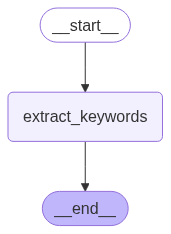

In [10]:
class KeyWordsModel(BaseModel):
    keywords: Annotated[list[str], "텍스트로 부터 추출한 키워드를 담는 리스트"]

llm = ChatOpenAI(
    model='gpt-4o',
    temperature=0
)
structured_llm = llm.with_structured_output(KeyWordsModel)

# Define State
class InputState(TypedDict):
    context: str

class OutputState(TypedDict):
    keywords: list[str]

class GraphState(InputState, OutputState):
    pass

# Define Nodes
def keyword_extraction_node(state: InputState):
    context = state['context']

    system_message_content = """
    당신은 전문적인 기업 트렌드 분석가 입니다.
    당신의 임무는 주어진 텍스트에서 기업 분석을 위한 주요 키워드를 추출하는 것입니다.
    다음의 지침을 준수하며 기업의 트렌드 분석이 가능하도록 키워드를 30개 추출하세요.

    <지침>
    1. '사업', '선두주자'와 같이 해당 기업에 대해 설명할 수 없는 너무 일반적인 키워드는 제외하세요.
    2. '~부문' 과 같이 특정 분야를 총괄하는 키워드는 제외하고, 기업에 대해 분석 가능한 직접적인 키워드를 선정하세요.
    </지침>
    """

    human_message_content = f"""
    다음의 텍스트에서 해당 기업의 트렌드 분석을 위한 키워드를 추출해주세요.

    텍스트:
    {context}
    """

    system_message = SystemMessage(content=system_message_content)
    human_message = HumanMessage(content=human_message_content)

    keyword_list = structured_llm.invoke([system_message, human_message])

    return {
        "keywords" : keyword_list.keywords
    }


# Define Graph Builder
workflow = StateGraph(
    GraphState,
    input=InputState,
    output=OutputState
)

# add nodes
workflow.add_node("extract_keywords", keyword_extraction_node)

# add edges
workflow.add_edge(START, "extract_keywords")
workflow.add_edge("extract_keywords", END)

# Compile Graph
app = workflow.compile()

app    


In [11]:
# app.invoke({"context" : text})

## Construct Evaluate Process

### Critic Function

In [12]:
def calculate_keyword_metrics(ground_truth, predicted):
    gt_set = set(ground_truth)
    pred_set = set(predicted)
    
    # True Positive: 예측한 키워드 중 정답에 포함된 것
    tp = len(gt_set.intersection(pred_set))
    # False Positive: 예측한 키워드 중 정답에 포함되지 않은 것
    fp = len(pred_set - gt_set)
    # False Negative: 정답 키워드 중 예측하지 못한 것
    fn = len(gt_set - pred_set)

    # Precision
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    # Recall
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    # F1 Score
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    return {
        'precision': precision,
        'recall': recall,
        'f1_score': f1_score,
        'tp': tp,
        'fp': fp,
        'fn': fn,
        'ground_truth_count': len(gt_set),
        'predicted_count': len(pred_set)
    }

### TextRank

In [15]:
stopwords = list(set(["종", "그", "및", "등", "각", "개", "를", "사", "위", "전", "용", "처", "통해", "기술", "부문", "경쟁력", "제품", "사업",
             "시장", "판매", "지속", "기업", "생산", "확대", "기업", "당사", "차별", "솔루션", "부품", "개발", "적용", "공정", "한편", "업체",
             "운영", "선두", "전장", "또한", "추진", "구성", "응용", "일반", "영위", "해외", "경영", "본사", "지역", "주요", "다음", "삼성",
             "협업", "서비스", "선단", "특화", "심화", "제품군", "설계", "대형", "세계", "소비자", "라인업", "혁신", "차세대", "공급", "글로벌", "고화질",
             "경쟁", "강화", "더블", "경험", "율", "의", "고하", "뿐", "로서", "탑재", "자체", "원가", "간", "수", "경우", "내", "따라서", "대한"]))

eval_results = []
for gt in tqdm(eval_dataset[:100], desc="TextRank Evaluating... : "):
    text = gt['context']
    gt_keywords = gt['terminology']

    textrank_extractor = TextRankKeywordExtractor(text, stopwords=stopwords)
    pred_keywords = textrank_extractor.extract(
        window=3,
        max_iter=30,
        top_n=30
    )

    eval_results.append(calculate_keyword_metrics(
        ground_truth=gt_keywords,
        predicted=pred_keywords
    ))

TextRank Evaluating... : 100%|██████████| 100/100 [00:02<00:00, 33.39it/s]


In [16]:
total_precision = 0
total_recall = 0
total_f1 = 0
total_gt_cnt = 0
total_pred_cnt = 0
eval_amount = len(eval_results)

for eval in eval_results:
    total_precision += eval['precision']
    total_recall += eval['recall']
    total_f1 += eval['f1_score']
    total_gt_cnt += eval['ground_truth_count']
    total_pred_cnt += eval['predicted_count']

print(
    f" Avg Precision : {total_precision / eval_amount}\n",
    f"Avg recall : {total_recall / eval_amount}\n",
    f"Avg f1 score : {total_f1 / eval_amount}\n",
    f"Avg ground truth count : {total_gt_cnt / eval_amount}\n",
    f"Avg predicted count : {total_pred_cnt / eval_amount}\n"
)

 Avg Precision : 0.10423194192377493
 Avg recall : 0.12393775441033852
 Avg f1 score : 0.10323048807776919
 Avg ground truth count : 32.19
 Avg predicted count : 29.76



### Embedding Based

In [17]:
stopwords = list(set(["종", "그", "및", "등", "각", "개", "를", "사", "위", "전", "용", "처", "통해", "기술", "부문", "경쟁력", "제품", "사업",
             "시장", "판매", "지속", "기업", "생산", "확대", "기업", "당사", "차별", "솔루션", "부품", "개발", "적용", "공정", "한편", "업체",
             "운영", "선두", "전장", "또한", "추진", "구성", "응용", "일반", "영위", "해외", "경영", "본사", "지역", "주요", "다음", "삼성",
             "협업", "서비스", "선단", "특화", "심화", "제품군", "설계", "대형", "세계", "소비자", "라인업", "혁신", "차세대", "공급", "글로벌", "고화질",
             "경쟁", "강화", "더블", "경험", "율", "의", "고하", "뿐", "로서", "탑재", "자체", "원가", "간", "수", "경우", "내", "따라서", "대한"]))

eval_results = []
for gt in tqdm(eval_dataset[:100], desc="Embedding Based Evaluating... : "):
    text = gt['context']
    gt_keywords = gt['terminology']

    embeddingbased_extractor = OpenAIEmbeddingBasedExtractor(text, stopwords=stopwords)
    pred_keywords = embeddingbased_extractor.extract(
        top_n=30
    )

    if len(pred_keywords) == 0:
        eval_results.append(calculate_keyword_metrics(
            ground_truth=gt_keywords,
            predicted=pred_keywords
        ))
    else:
        eval_results.append(calculate_keyword_metrics(
            ground_truth=gt_keywords,
            predicted=pred_keywords[0]
        ))    

Embedding Based Evaluating... : 100%|██████████| 100/100 [03:39<00:00,  2.20s/it]


In [19]:
total_precision = 0
total_recall = 0
total_f1 = 0
total_gt_cnt = 0
total_pred_cnt = 0
eval_amount = len(eval_results)

for eval in eval_results:
    total_precision += eval['precision']
    total_recall += eval['recall']
    total_f1 += eval['f1_score']
    total_gt_cnt += eval['ground_truth_count']
    total_pred_cnt += eval['predicted_count']

print(
    f" Avg Precision : {total_precision / eval_amount}\n",
    f"Avg recall : {total_recall / eval_amount}\n",
    f"Avg f1 score : {total_f1 / eval_amount}\n",
    f"Avg ground truth count : {total_gt_cnt / eval_amount}\n",
    f"Avg predicted count : {total_pred_cnt / eval_amount}\n"
)

 Avg Precision : 0.14589860859044146
 Avg recall : 0.1681523442769958
 Avg f1 score : 0.14262896542578957
 Avg ground truth count : 32.19
 Avg predicted count : 29.76



### KeyBERT

In [20]:
stopwords = list(set(["종", "그", "및", "등", "각", "개", "를", "사", "위", "전", "용", "처", "통해", "기술", "부문", "경쟁력", "제품", "사업",
             "시장", "판매", "지속", "기업", "생산", "확대", "기업", "당사", "차별", "솔루션", "부품", "개발", "적용", "공정", "한편", "업체",
             "운영", "선두", "전장", "또한", "추진", "구성", "응용", "일반", "영위", "해외", "경영", "본사", "지역", "주요", "다음", "삼성",
             "협업", "서비스", "선단", "특화", "심화", "제품군", "설계", "대형", "세계", "소비자", "라인업", "혁신", "차세대", "공급", "글로벌", "고화질",
             "경쟁", "강화", "더블", "경험", "율", "의", "고하", "뿐", "로서", "탑재", "자체", "원가", "간", "수", "경우", "내", "따라서", "대한"]))

eval_results = []
for gt in tqdm(eval_dataset[:100], desc="KeyBERT Evaluating... : "):
    text = gt['context']
    gt_keywords = gt['terminology']

    model = BertModel.from_pretrained('skt/kobert-base-v1')
    keybert_extractor = KeyBERTExtractor(text, model=model, stopwords=stopwords)
    pred_keywords = keybert_extractor.extract(
        top_n=30
    )

    if len(pred_keywords) == 0:
        eval_results.append(calculate_keyword_metrics(
            ground_truth=gt_keywords,
            predicted=pred_keywords
        ))
    else:
        pred_keywords = [word for word, score in pred_keywords]
        eval_results.append(calculate_keyword_metrics(
            ground_truth=gt_keywords,
            predicted=pred_keywords
        ))

KeyBERT Evaluating... :  16%|█▌        | 16/100 [01:06<05:39,  4.04s/it]HTTP Error 429 thrown while requesting HEAD https://huggingface.co/sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2/resolve/main/1_Pooling/config.json
Retrying in 1s [Retry 1/5].
HTTP Error 429 thrown while requesting HEAD https://huggingface.co/sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2/resolve/main/1_Pooling/config.json
Retrying in 2s [Retry 2/5].
HTTP Error 429 thrown while requesting HEAD https://huggingface.co/sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2/resolve/main/1_Pooling/config.json
Retrying in 4s [Retry 3/5].
HTTP Error 429 thrown while requesting HEAD https://huggingface.co/sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2/resolve/main/1_Pooling/config.json
Retrying in 8s [Retry 4/5].
HTTP Error 429 thrown while requesting HEAD https://huggingface.co/sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2/resolve/main/1_Pooling/config.json
Retryi

In [21]:
total_precision = 0
total_recall = 0
total_f1 = 0
total_gt_cnt = 0
total_pred_cnt = 0
eval_amount = len(eval_results)

for eval in eval_results:
    total_precision += eval['precision']
    total_recall += eval['recall']
    total_f1 += eval['f1_score']
    total_gt_cnt += eval['ground_truth_count']
    total_pred_cnt += eval['predicted_count']

print(
    f" Avg Precision : {total_precision / eval_amount}\n",
    f"Avg recall : {total_recall / eval_amount}\n",
    f"Avg f1 score : {total_f1 / eval_amount}\n",
    f"Avg ground truth count : {total_gt_cnt / eval_amount}\n",
    f"Avg predicted count : {total_pred_cnt / eval_amount}\n"
)

 Avg Precision : 0.13720330394243427
 Avg recall : 0.1555867222443692
 Avg f1 score : 0.13414991838596302
 Avg ground truth count : 32.19
 Avg predicted count : 29.29



In [27]:
stopwords = list(set(["종", "그", "및", "등", "각", "개", "를", "사", "위", "전", "용", "처", "통해", "기술", "부문", "경쟁력", "제품", "사업",
             "시장", "판매", "지속", "기업", "생산", "확대", "기업", "당사", "차별", "솔루션", "부품", "개발", "적용", "공정", "한편", "업체",
             "운영", "선두", "전장", "또한", "추진", "구성", "응용", "일반", "영위", "해외", "경영", "본사", "지역", "주요", "다음", "삼성",
             "협업", "서비스", "선단", "특화", "심화", "제품군", "설계", "대형", "세계", "소비자", "라인업", "혁신", "차세대", "공급", "글로벌", "고화질",
             "경쟁", "강화", "더블", "경험", "율", "의", "고하", "뿐", "로서", "탑재", "자체", "원가", "간", "수", "경우", "내", "따라서", "대한"]))

eval_results = []
for gt in tqdm(eval_dataset[:100], desc="KeyBERT Evaluating... : "):
    text = gt['context']
    gt_keywords = gt['terminology']

    model = BertModel.from_pretrained('skt/kobert-base-v1')
    keybert_extractor = KeyBERTExtractor(text, model=model, stopwords=stopwords)
    pred_keywords = keybert_extractor.extract(
        top_n=30,
        use_mmr=True,
        use_msum=True
    )

    if len(pred_keywords) == 0:
        eval_results.append(calculate_keyword_metrics(
            ground_truth=gt_keywords,
            predicted=pred_keywords
        ))
    else:
        pred_keywords = [word for word, score in pred_keywords]
        eval_results.append(calculate_keyword_metrics(
            ground_truth=gt_keywords,
            predicted=pred_keywords
        ))

KeyBERT Evaluating... :  16%|█▌        | 16/100 [01:06<05:52,  4.20s/it]HTTP Error 429 thrown while requesting HEAD https://huggingface.co/sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2/resolve/main/config.json
Retrying in 1s [Retry 1/5].
HTTP Error 429 thrown while requesting HEAD https://huggingface.co/sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2/resolve/main/config.json
Retrying in 2s [Retry 2/5].
HTTP Error 429 thrown while requesting HEAD https://huggingface.co/sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2/resolve/main/config.json
Retrying in 4s [Retry 3/5].
HTTP Error 429 thrown while requesting HEAD https://huggingface.co/sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2/resolve/main/config.json
Retrying in 8s [Retry 4/5].
HTTP Error 429 thrown while requesting HEAD https://huggingface.co/sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2/resolve/main/config.json
Retrying in 8s [Retry 5/5].
HTTP Error 429 thrown while 

In [28]:
total_precision = 0
total_recall = 0
total_f1 = 0
total_gt_cnt = 0
total_pred_cnt = 0
eval_amount = len(eval_results)

for eval in eval_results:
    total_precision += eval['precision']
    total_recall += eval['recall']
    total_f1 += eval['f1_score']
    total_gt_cnt += eval['ground_truth_count']
    total_pred_cnt += eval['predicted_count']

print(
    f" Avg Precision : {total_precision / eval_amount}\n",
    f"Avg recall : {total_recall / eval_amount}\n",
    f"Avg f1 score : {total_f1 / eval_amount}\n",
    f"Avg ground truth count : {total_gt_cnt / eval_amount}\n",
    f"Avg predicted count : {total_pred_cnt / eval_amount}\n"
)

 Avg Precision : 0.12286997060910097
 Avg recall : 0.1424349653012377
 Avg f1 score : 0.12057443446260702
 Avg ground truth count : 32.19
 Avg predicted count : 29.29



### LLM Based

In [24]:
eval_results = []
for gt in tqdm(eval_dataset[:100], desc="LLM Based Evaluating... : "):
    text = gt['context']
    gt_keywords = gt['terminology']

    pred_keywords = app.invoke({"context" : text})

    eval_results.append(calculate_keyword_metrics(
        ground_truth=gt_keywords,
        predicted=pred_keywords['keywords']
    ))

LLM Based Evaluating... : 100%|██████████| 100/100 [06:53<00:00,  4.13s/it]


In [26]:
total_precision = 0
total_recall = 0
total_f1 = 0
total_gt_cnt = 0
total_pred_cnt = 0
eval_amount = len(eval_results)

for eval in eval_results:
    total_precision += eval['precision']
    total_recall += eval['recall']
    total_f1 += eval['f1_score']
    total_gt_cnt += eval['ground_truth_count']
    total_pred_cnt += eval['predicted_count']

print(
    f" Avg Precision : {total_precision / eval_amount}\n",
    f"Avg recall : {total_recall / eval_amount}\n",
    f"Avg f1 score : {total_f1 / eval_amount}\n",
    f"Avg ground truth count : {total_gt_cnt / eval_amount}\n",
    f"Avg predicted count : {total_pred_cnt / eval_amount}\n"
)

 Avg Precision : 0.3088381535038931
 Avg recall : 0.33853279721375207
 Avg f1 score : 0.2964641477502071
 Avg ground truth count : 32.19
 Avg predicted count : 29.91

